In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
import numpy as np
import json
import pickle
import random
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
# we want to find a function that has huge approximation error

true integral value 4.9256988177876543e-17
10 1.9491444561474052e-15 -1.190367249215285e-14
100 1.2349245375497358e-14 -1.5244533066449684e-14
1000 -1.1094300959461822e-16 1.559108135022573e-16
10000.0 -4.8127459189697775e-18 -2.838664163111297e-17
100000.0 -5.297106552418659e-17 -4.6797458811851976e-18


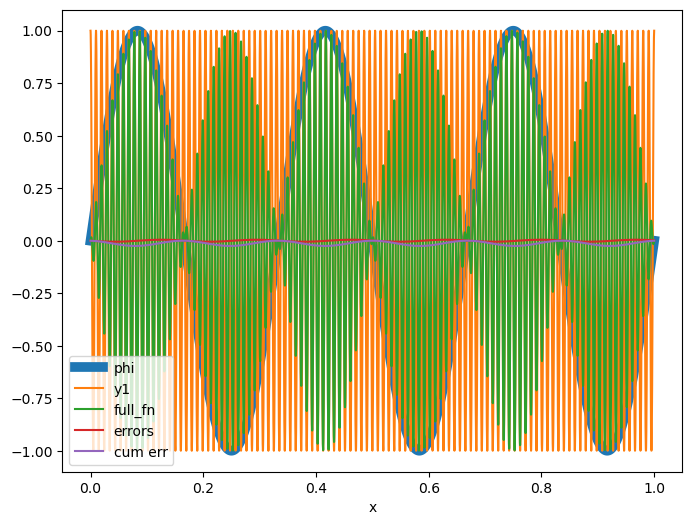

In [12]:
n_true = 1e2 # the "n" in the proof
n_plot = 1e4 # the n used for plotting
n_high_res = 1e6 # the n used for computing a low-error integral

n_tests = [10, 100, 1000, 1e4, 1e5] # all the n's we will evaluate

omega = 3

x_plot = np.linspace(0, 1, int(n_plot))
x_true = np.linspace(0, 1, int(n_true))

def phi(x):
    # projection to the real part of the Fourier basis
    return np.sin(2*np.pi*omega*x)

def inverse(x):
    # one of the functions I am testing
    f = np.divide(x,np.sin(2*np.pi*omega*x))
    threshold = 2
    mask = f > threshold
    f[mask] = threshold
    mask = f < -threshold
    f[mask] = -threshold
    return f

# try out lots of functions
def y(x):
# todo: update numbers
#    return np.ones_like(x) # 1e-16
#    return x # 1e-7 (and as high as .25)
#    return inverse(x) # 1e-6 # (as high as .5, but doesn't work yet, since it loses a lot near 0
#    return x **2 # 1e-7
#    return phi(x) # 1e-15
#    return np.cos(2*np.pi*omega*x) # 1e-15
    return np.sin(2*np.pi*(n_true + omega)*x) # -0.5 ######################
#    return np.cos(2*np.pi*(n_true + omega)*x) # 1e-14
#    return np.cos(2*np.pi*n_true*x) # 1e-14


def full_func(x):
    # this is y * Fourier basis; the function we want to integrate
    return np.multiply(phi(x),y(x))


def right_riemann_sum(f, n):
    """Compute the right Riemann sum of f from 0 to 1 with n steps."""
    func = f(np.linspace(0, 1, int(n), endpoint=False))
    #print('lin r', np.linspace(0, 1, int(n), endpoint=False)[:5])
    #print('deb r', np.round(func[:5],5), n)
    return sum(func / n)

def riemann_sum_err(f, n_highres, n):
    """
    Compute the error of the right Riemann sum of f from 0 to 1 with n steps.
    n is the steps for which we compute the error.
    The integral with n_full steps is considered the ground truth
    """
    n_highres = int(n_highres)
    n = int(n)
    high_res_parts = np.zeros(n)
    low_res_parts = np.zeros(n)
    for i in range(n):
        func = f(np.linspace(i/n, (i+1)/n, int(n_highres/n), endpoint=False))
        high_res_parts[i] = sum(func) / int(n_highres/n) # "true integral, n_highres steps"
        low_res_parts[i] = func[0] # "approximation of integral, n steps"
    integral_high_res = sum(high_res_parts) / n
    integral_low_res = sum(low_res_parts) / n
    errors = (high_res_parts - low_res_parts) / n
    #print('lin s', [i/n for i in range(n)][:5])
    #print('val s', np.round(low_res_parts[:5],5))
    #print('debug lowres highres', integral_high_res, integral_low_res)
    return high_res_parts, errors

true_integral = right_riemann_sum(full_func, n_high_res)
print('true integral value', true_integral)
for n_test in n_tests:
    full_error = right_riemann_sum(full_func, n_test) - true_integral
    error_sequentially = sum(riemann_sum_err(full_func, n_high_res, n_test)[1])
    print(n_test, full_error, error_sequentially)

# create the plot
plt.figure(figsize=(8,6))
plt.plot(x_plot, phi(x_plot), label='phi', linewidth=7.0)
plt.plot(x_plot, y(x_plot), label='y1')
plt.plot(x_plot, full_func(x_plot), label='full_fn')

errors = riemann_sum_err(full_func, n_high_res, n_true)[1]
total_error = sum(errors)
max_error = np.max(errors)
cum_err = np.cumsum(errors)




plt.plot(x_true, errors, label='errors')
plt.plot(x_true, cum_err, label='cum err')

plt.xlabel('x')
plt.legend()
plt.show()
